# An unoffical demo for training MCNN on Shanghai tech dataset (Part-B)

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

## visualize

In [3]:
def show(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

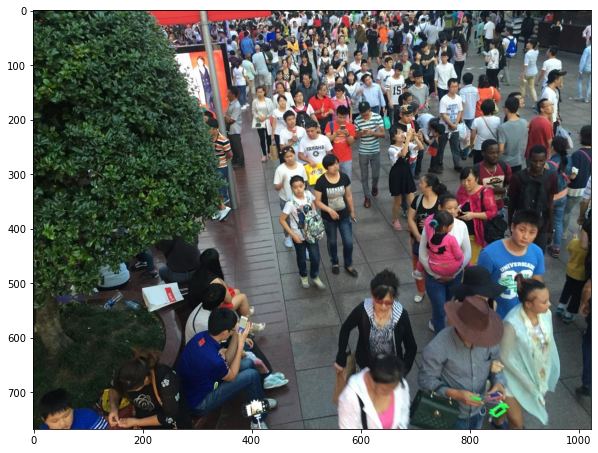

In [4]:
im = cv2.imread('../input/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

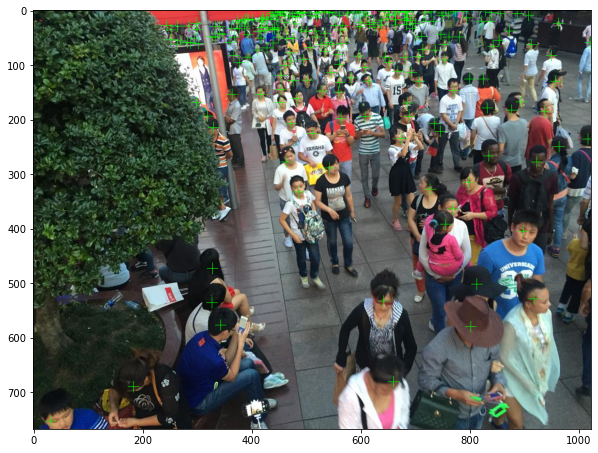

In [5]:
m = scipy.io.loadmat('../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))
    
show(im)

## Prepare dataset

In [6]:
from sklearn.model_selection import train_test_split

train = [p.path for p in os.scandir('../input/shanghaitech/ShanghaiTech/part_B/train_data/images/')]
valid_full = [p.path for p in os.scandir('../input/shanghaitech/ShanghaiTech/part_B/test_data/images/')]

## use a small subset for validation
_, valid = train_test_split(valid_full, test_size=64, random_state=42)

len(train), len(valid)

(400, 64)

In [7]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
im_size = 512
aug_train = A.Compose([
    A.RandomCrop(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]
        
        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']
        
        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
        
        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16
        
        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)
        
        return im, dm

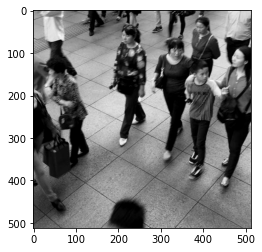

In [9]:
ds = MyDataset(train, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

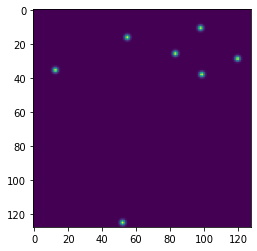

In [10]:
plt.imshow(dm)

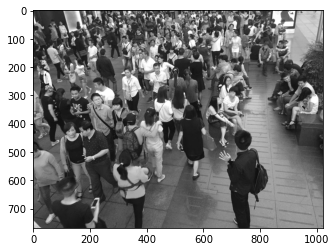

In [11]:
ds = MyDataset(valid, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

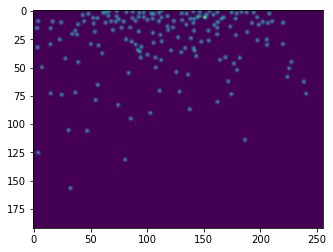

In [12]:
plt.imshow(dm)

In [13]:
dm.sum()

tensor(165.0000)

## Building Model

In [14]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


In [15]:
class MCNN(LightningModule):
    '''
    Multi-column CNN 
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''
    
    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()
        
        self.lr = lr
        self.save_hyperparameters()
        
        self.use = 0
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))
        
        self.crit = nn.MSELoss()
        
    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        
        
        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)
        
        return x.squeeze(1)
    
    
    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        
        pred = self(x)
        loss = self.crit(pred, y)
        
        pred_sum = torch.round(pred.sum(dim=(1,2))).int()
        gt_sum = torch.round(y.sum(dim=(1,2))).int()
        acc = (pred_sum == gt_sum).float().mean()
        
        mae = torch.abs(pred_sum - gt_sum).float().mean()
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_mae', mae)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch
            
            pred = self(x)
            loss = self.crit(pred, y)
        
            pred_sum = torch.round(pred.sum(dim=(1,2))).int()
            gt_sum = torch.round(y.sum(dim=(1,2))).int()
            acc = (pred_sum == gt_sum).float().mean()

            mae = torch.abs(pred_sum - gt_sum).float().mean()
            
            self.log('val_loss', loss)
            self.log('val_acc', acc)
            self.log('val_mae', mae)
            
            
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
            'interval': 'step',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]

### weight init is crucial for the model to converge

In [16]:
def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

## Training

In [17]:
batch_size = 32
epochs = 300
max_steps = epochs * len(train) // batch_size

In [18]:
train_loader = DataLoader(MyDataset(train, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(MyDataset(valid, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

### training

In [19]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min',
    prefix=''
)

trainer = Trainer(gpus=1, max_steps=max_steps, precision=16, benchmark=True, callbacks=[checkpoint_cb, LearningRateMonitor()])

lr = 3e-4

model = MCNN(lr, batch_size, max_steps)
weights_normal_init(model, dev=0.01)

model.use = 0

trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | out1    | Sequential | 9     
5 | out2    | Sequential | 11    
6 | out3    | Sequential | 13    
7 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: val_mae reached 96.71875 (best 96.71875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=0-step=11.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 23: val_mae reached 87.78125 (best 87.78125), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=1-step=23.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 35: val_mae reached 77.40625 (best 77.40625), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=2-step=35.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 47: val_mae reached 66.79688 (best 66.79688), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=3-step=47.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 59: val_mae reached 56.93750 (best 56.93750), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=4-step=59.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 71: val_mae reached 53.71875 (best 53.71875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=5-step=71.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 6, step 83: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 95: val_mae reached 53.64062 (best 53.64062), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=7-step=95.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 107: val_mae reached 53.17188 (best 53.17188), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=8-step=107.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 9, step 119: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 10, step 131: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 143: val_mae reached 47.34375 (best 47.34375), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=11-step=143.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 155: val_mae reached 45.96875 (best 45.96875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=12-step=155.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 167: val_mae reached 45.29688 (best 45.29688), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=13-step=167.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 14, step 179: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 191: val_mae reached 44.82812 (best 44.82812), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=15-step=191.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 203: val_mae reached 44.07812 (best 44.07812), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=16-step=203.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 215: val_mae reached 43.23438 (best 43.23438), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=17-step=215.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 227: val_mae reached 42.60938 (best 42.60938), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=18-step=227.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 19, step 239: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 20, step 251: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 21, step 263: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 22, step 275: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 23, step 287: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 24, step 299: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 25, step 311: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 26, step 323: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 27, step 335: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 28, step 347: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 29, step 359: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 30, step 371: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 31, step 383: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 32, step 395: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 33, step 407: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 34, step 419: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 35, step 431: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 36, step 443: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 37, step 455: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 38, step 467: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 39, step 479: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 40, step 491: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 41, step 503: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 42, step 515: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 43, step 527: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 44, step 539: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 45, step 551: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 46, step 563: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 47, step 575: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 48, step 587: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 49, step 599: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 50, step 611: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 51, step 623: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 635: val_mae reached 40.01562 (best 40.01562), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=52-step=635.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 53, step 647: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 54, step 659: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 55, step 671: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 56, step 683: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 57, step 695: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 58, step 707: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 59, step 719: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 731: val_mae reached 38.84375 (best 38.84375), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=60-step=731.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 61, step 743: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 62, step 755: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 63, step 767: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 64, step 779: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 65, global step 791: val_mae reached 38.28125 (best 38.28125), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=65-step=791.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 803: val_mae reached 37.96875 (best 37.96875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=66-step=803.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 67, step 815: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 68, step 827: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 69, step 839: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 70, step 851: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 71, step 863: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 72, step 875: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 887: val_mae reached 37.79688 (best 37.79688), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=73-step=887.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 74, step 899: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 75, step 911: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 76, step 923: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 77, global step 935: val_mae reached 37.56250 (best 37.56250), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=77-step=935.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 78, step 947: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 79, step 959: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 80, step 971: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 81, global step 983: val_mae reached 36.96875 (best 36.96875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=81-step=983.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 82, step 995: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 83, step 1007: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 84, step 1019: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 85, step 1031: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 86, step 1043: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 87, step 1055: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 88, global step 1067: val_mae reached 33.71875 (best 33.71875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=88-step=1067.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 89, step 1079: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 90, step 1091: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 91, step 1103: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 1115: val_mae reached 33.07812 (best 33.07812), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=92-step=1115.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 93, step 1127: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 94, step 1139: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 95, step 1151: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 96, step 1163: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 97, step 1175: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 98, step 1187: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 99, step 1199: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 100, step 1211: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 101, step 1223: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 102, step 1235: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 103, global step 1247: val_mae reached 32.45312 (best 32.45312), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=103-step=1247.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 104, step 1259: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 105, step 1271: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 106, step 1283: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 107, global step 1295: val_mae reached 32.12500 (best 32.12500), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=107-step=1295.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 108, step 1307: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 109, global step 1319: val_mae reached 29.98438 (best 29.98438), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=109-step=1319.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 110, step 1331: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 111, step 1343: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 112, step 1355: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 113, step 1367: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 114, step 1379: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 115, step 1391: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 116, step 1403: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 117, step 1415: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 118, step 1427: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 119, step 1439: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 120, step 1451: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 121, step 1463: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 122, step 1475: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 123, step 1487: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 124, step 1499: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 125, step 1511: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 126, global step 1523: val_mae reached 26.96875 (best 26.96875), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=126-step=1523.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 127, step 1535: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 128, step 1547: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 129, step 1559: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 130, step 1571: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 131, step 1583: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 132, step 1595: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 133, step 1607: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 134, step 1619: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 135, step 1631: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 136, step 1643: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 137, step 1655: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 138, step 1667: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 139, global step 1679: val_mae reached 26.53125 (best 26.53125), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=139-step=1679.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 140, step 1691: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 141, step 1703: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 142, step 1715: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 143, step 1727: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 144, global step 1739: val_mae reached 25.81250 (best 25.81250), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=144-step=1739.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 145, step 1751: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 146, step 1763: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 147, step 1775: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 148, step 1787: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 149, step 1799: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 150, step 1811: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 151, step 1823: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 152, step 1835: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 153, step 1847: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 154, step 1859: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 155, step 1871: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 156, step 1883: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 157, step 1895: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 158, step 1907: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 159, global step 1919: val_mae reached 25.51562 (best 25.51562), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=159-step=1919.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 160, step 1931: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 161, step 1943: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 162, step 1955: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 163, step 1967: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 164, step 1979: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 165, step 1991: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 166, step 2003: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 167, step 2015: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 168, step 2027: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 169, step 2039: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 170, step 2051: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 171, step 2063: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 172, step 2075: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 173, step 2087: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 174, step 2099: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 175, step 2111: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 176, step 2123: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 177, step 2135: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 178, step 2147: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 179, global step 2159: val_mae reached 23.14062 (best 23.14062), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=179-step=2159.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 180, step 2171: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 181, step 2183: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 182, step 2195: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 183, step 2207: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 184, step 2219: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 185, step 2231: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 186, step 2243: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 187, step 2255: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 188, step 2267: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 189, step 2279: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 190, step 2291: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 191, step 2303: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 192, step 2315: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 193, step 2327: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 194, step 2339: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 195, step 2351: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 196, step 2363: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 197, step 2375: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 198, step 2387: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 199, step 2399: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 200, step 2411: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 201, step 2423: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 202, step 2435: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 203, step 2447: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 204, step 2459: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 205, global step 2471: val_mae reached 22.45312 (best 22.45312), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=205-step=2471.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 206, step 2483: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 207, step 2495: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 208, step 2507: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 209, step 2519: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 210, step 2531: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 211, step 2543: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 212, step 2555: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 213, step 2567: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 214, step 2579: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 215, step 2591: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 216, step 2603: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 217, global step 2615: val_mae reached 22.07812 (best 22.07812), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=217-step=2615.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 218, step 2627: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 219, step 2639: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 220, global step 2651: val_mae reached 21.65625 (best 21.65625), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=220-step=2651.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 221, step 2663: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 222, step 2675: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 223, step 2687: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 224, step 2699: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 225, step 2711: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 226, step 2723: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 227, step 2735: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 228, step 2747: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 229, step 2759: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 230, step 2771: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 231, step 2783: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 232, step 2795: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 233, global step 2807: val_mae reached 21.54688 (best 21.54688), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=233-step=2807.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 234, step 2819: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 235, step 2831: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 236, step 2843: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 237, step 2855: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 238, global step 2867: val_mae reached 21.50000 (best 21.50000), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=238-step=2867.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 239, step 2879: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 240, step 2891: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 241, step 2903: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 242, step 2915: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 243, step 2927: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 244, step 2939: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 245, step 2951: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 246, step 2963: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 247, step 2975: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 248, step 2987: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 249, step 2999: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 250, step 3011: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 251, step 3023: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 252, step 3035: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 253, step 3047: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 254, step 3059: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 255, step 3071: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 256, step 3083: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 257, step 3095: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 258, step 3107: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 259, step 3119: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 260, step 3131: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 261, step 3143: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 262, step 3155: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 263, step 3167: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 264, step 3179: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 265, step 3191: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 266, step 3203: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 267, global step 3215: val_mae reached 21.32812 (best 21.32812), saving model to "/kaggle/working/lightning_logs/version_0/checkpoints/epoch=267-step=3215.ckpt" as top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 268, step 3227: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 269, step 3239: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 270, step 3251: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 271, step 3263: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 272, step 3275: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 273, step 3287: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 274, step 3299: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 275, step 3311: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 276, step 3323: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 277, step 3335: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 278, step 3347: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 279, step 3359: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 280, step 3371: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 281, step 3383: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 282, step 3395: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 283, step 3407: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 284, step 3419: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 285, step 3431: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 286, step 3443: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 287, step 3455: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 288, step 3467: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 289, step 3479: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 290, step 3491: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 291, step 3503: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 292, step 3515: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 293, step 3527: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 294, step 3539: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 295, step 3551: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 296, step 3563: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 297, step 3575: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 298, step 3587: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 299, step 3599: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 300, step 3611: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 301, step 3623: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 302, step 3635: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 303, step 3647: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 304, step 3659: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 305, step 3671: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 306, step 3683: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 307, step 3695: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 308, step 3707: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 309, step 3719: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 310, step 3731: val_mae was not in top 1


Validating: |          | 0/? [00:00<?, ?it/s]

Epoch 311, step 3743: val_mae was not in top 1
Saving latest checkpoint...
Epoch 312, step 3749: val_mae was not in top 1


1

## Separate column training

In [20]:
# from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
# seed_everything(42)

# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# lr = 3e-4

# model = MCNN(lr, batch_size, max_steps)
# weights_normal_init(model, dev=0.01)

# model.use = 1

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [21]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 2

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [22]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 3

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [23]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 0

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

## Visualize the result
We can see that the recognition results highlight the human body

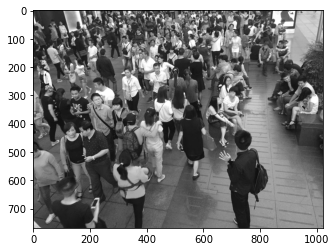

In [24]:
ds = MyDataset(valid, aug_val)
d = ds[0][0]
plt.imshow(d, cmap='gray')

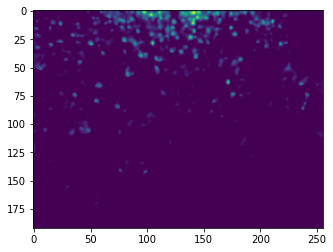

In [25]:
plt.imshow(model(d.unsqueeze(0)).detach()[0])

In [26]:
model(d.unsqueeze(0)).detach()[0].sum()

tensor(153.9818)